In [1]:
# ─── Cell 1: IMPORTS & DATA LOAD ────────────────────────────────────────────────
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Load cleaned data
df = pd.read_csv("../data/processed/cleaned_loans2.csv")

# Quick sanity checks
print("Data shape:", df.shape)
print("\nDefault flag distribution (proportion):")
print(df['default_flag'].value_counts(normalize=True))


Data shape: (2260701, 131)

Default flag distribution (proportion):
default_flag
0    0.869768
1    0.130232
Name: proportion, dtype: float64


In [2]:
# ─── Cell 2: SPLIT & TRAIN ──────────────────────────────────────────────────────
# 1. Define features & target
X = df.drop(columns=['default_flag'])
y = df['default_flag']

# 2. Train/test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 3. Initialize and train Logistic Regression
lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(X_train, y_train)
print("Model training complete.")


Train shape: (1808560, 130) Test shape: (452141, 130)
Model training complete.


In [3]:
# ─── Cell 3: BASELINE EVALUATION ────────────────────────────────────────────────
# Predictions & probabilities
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

# Compute metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_prob)

# Print results
print(f"Accuracy:    {acc:.4f}")
print(f"Precision:   {prec:.4f}")
print(f"Recall:      {rec:.4f}")
print(f"F1 Score:    {f1:.4f}")
print(f"ROC-AUC:     {roc:.4f}")


Accuracy:    0.8842
Precision:   0.8396
Recall:      0.1372
F1 Score:    0.2358
ROC-AUC:     0.7671


In [4]:
# ─── Cell 4: THRESHOLD TUNING ──────────────────────────────────────────────────
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.1, 0.9, 0.1)
print("Thresh  Precision   Recall")
for t in thresholds:
    preds_t = (y_prob >= t).astype(int)
    p = precision_score(y_test, preds_t)
    r = recall_score(y_test, preds_t)
    print(f"{t:>5.2f}   {p:>8.4f}   {r:>8.4f}")


Thresh  Precision   Recall
 0.10     0.2207     0.7871
 0.20     0.3610     0.4267
 0.30     0.5014     0.2541
 0.40     0.6698     0.1742
 0.50     0.8396     0.1372
 0.60     0.9413     0.1239
 0.70     0.9870     0.1190
 0.80     0.9977     0.1180


In [5]:
# ─── Cell 5: EVALUATE AT THRESHOLD 0.20 ────────────────────────────────────────
from sklearn.metrics import precision_score, recall_score

threshold = 0.20
y_pred_t = (y_prob >= threshold).astype(int)

print(f"Metrics at threshold = {threshold:.2f}:")
print("  Precision:", precision_score(y_test, y_pred_t))
print("  Recall:   ", recall_score(y_test, y_pred_t))


Metrics at threshold = 0.20:
  Precision: 0.3610304893818788
  Recall:    0.4267275784182192


In [6]:
# ─── Cell 6: FEATURE IMPORTANCE ─────────────────────────────────────────────────
import pandas as pd

# Coefficients from the trained model
coef = pd.Series(lr.coef_[0], index=X.columns)

# Top 10 by absolute value
top10 = coef.abs().sort_values(ascending=False).head(10)
print("Top 10 features by absolute coefficient (abs):\n", top10)

# And their signed impact
print("\nSigned coefficients (positive → higher PD, negative → lower PD):")
print(coef[top10.index])


Top 10 features by absolute coefficient (abs):
 debt_settlement_flag_Y           10.906848
hardship_flag_Y                   2.696841
pymnt_plan_y                      1.990420
funded_amnt_inv                   1.047006
disbursement_method_DirectPay     0.897628
purpose_wedding                   0.798408
sub_grade_enc                     0.701814
loan_amnt                         0.665252
home_ownership_MORTGAGE           0.611808
funded_amnt                       0.513606
dtype: float64

Signed coefficients (positive → higher PD, negative → lower PD):
debt_settlement_flag_Y           10.906848
hardship_flag_Y                   2.696841
pymnt_plan_y                      1.990420
funded_amnt_inv                   1.047006
disbursement_method_DirectPay    -0.897628
purpose_wedding                  -0.798408
sub_grade_enc                     0.701814
loan_amnt                        -0.665252
home_ownership_MORTGAGE          -0.611808
funded_amnt                      -0.513606
dtype: floa

In [7]:
# ─── Cell 7: IDENTIFY HIGH-IMPACT FEATURES ─────────────────────────────────────
import pandas as pd

# Reuse the trained model and coefficient series from before
coef = pd.Series(lr.coef_[0], index=X.columns)

# Threshold for “low impact”
thresh = 0.05
high_imp = coef.abs()[coef.abs() >= thresh].index.tolist()
low_imp  = coef.abs()[coef.abs() <  thresh].index.tolist()

print(f"Keeping {len(high_imp)} features, dropping {len(low_imp)} low-impact features.")


Keeping 86 features, dropping 44 low-impact features.


In [8]:
# ─── Cell 8: RETRAIN ON HIGH-IMPACT ONLY ────────────────────────────────────────
# Subset train/test
X_train_hi = X_train[high_imp]
X_test_hi  = X_test[high_imp]

# Retrain Logistic Regression
lr_hi = LogisticRegression(max_iter=2000, n_jobs=-1)
lr_hi.fit(X_train_hi, y_train)
print("Retrained logistic on high-impact features only.")


Retrained logistic on high-impact features only.


In [9]:
# ─── Cell 9: EVALUATE REFINED MODEL ─────────────────────────────────────────────
# Predict & score
y_prob_hi = lr_hi.predict_proba(X_test_hi)[:, 1]
y_pred_hi = (y_prob_hi >= 0.20).astype(int)

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
print("Refined model metrics at threshold 0.20:")
print(" Accuracy: ", accuracy_score(y_test, y_pred_hi))
print(" Precision:", precision_score(y_test, y_pred_hi))
print(" Recall:   ", recall_score(y_test, y_pred_hi))
print(" F1 Score: ", f1_score(y_test, y_pred_hi))
print(" ROC-AUC:  ", roc_auc_score(y_test, y_prob_hi))


Refined model metrics at threshold 0.20:
 Accuracy:  0.8273171422189096
 Precision: 0.3612388305717012
 Recall:    0.4242990336769526
 F1 Score:  0.39023780702096916
 ROC-AUC:   0.7659678712320432


In [10]:
# ─── Cell 10: FIND BEST THRESHOLD FOR MAX F1 ───────────────────────────────────
import numpy as np
from sklearn.metrics import f1_score

# Use the original probabilities from lr (all features) or lr_hi (pruned)? 
# Let’s use the pruned model’s probs (y_prob_hi) for consistency.
probs = y_prob_hi  

thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = [f1_score(y_test, (probs >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_t   = thresholds[best_idx]
best_f1  = f1_scores[best_idx]

print(f"Best threshold = {best_t:.2f} → F1 = {best_f1:.4f}")


Best threshold = 0.18 → F1 = 0.3922


In [11]:
# ─── Cell 11: DECISION TREE ─────────────────────────────────────────────────────
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Initialize & train
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# 2. Predict & score on test set
y_prob_dt = dt.predict_proba(X_test)[:, 1]
y_pred_dt = dt.predict(X_test)

print("Decision Tree (threshold=0.5) metrics:")
print(" Accuracy:  ", accuracy_score(y_test, y_pred_dt))
print(" Precision: ", precision_score(y_test, y_pred_dt))
print(" Recall:    ", recall_score(y_test, y_pred_dt))
print(" F1 Score:  ", f1_score(y_test, y_pred_dt))
print(" ROC-AUC:   ", roc_auc_score(y_test, y_prob_dt))


Decision Tree (threshold=0.5) metrics:
 Accuracy:   0.8063082091648401
 Precision:  0.27810001082703045
 Recall:     0.3053512898459657
 F1 Score:   0.2910892371454475
 ROC-AUC:    0.593334194780837


In [12]:
# ─── Cell 12: RANDOM FOREST ────────────────────────────────────────────────────
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Initialize & train
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 2. Predict & score
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

print("Random Forest (threshold=0.5) metrics:")
print(" Accuracy:  ", accuracy_score(y_test, y_pred_rf))
print(" Precision: ", precision_score(y_test, y_pred_rf))
print(" Recall:    ", recall_score(y_test, y_pred_rf))
print(" F1 Score:  ", f1_score(y_test, y_pred_rf))
print(" ROC-AUC:   ", roc_auc_score(y_test, y_prob_rf))


Random Forest (threshold=0.5) metrics:
 Accuracy:   0.8851840465695435
 Precision:  0.9550796552624706
 Recall:     0.12421242124212421
 F1 Score:   0.21983438782104267
 ROC-AUC:    0.7660841184894907


In [13]:
# ─── Cell 13: XGBOOST ──────────────────────────────────────────────────────────
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Initialize & train
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
xgb_clf.fit(X_train, y_train)

# 2. Predict & score
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost (threshold=0.5) metrics:")
print(" Accuracy:  ", accuracy_score(y_test, y_pred_xgb))
print(" Precision: ", precision_score(y_test, y_pred_xgb))
print(" Recall:    ", recall_score(y_test, y_pred_xgb))
print(" F1 Score:  ", f1_score(y_test, y_pred_xgb))
print(" ROC-AUC:   ", roc_auc_score(y_test, y_prob_xgb))


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:12:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (threshold=0.5) metrics:
 Accuracy:   0.8854538739021677
 Precision:  0.8970884658454648
 Recall:     0.13604945400200397
 F1 Score:   0.2362673823603144
 ROC-AUC:    0.7879423486449176


In [14]:
# ─── Cell 14: THRESHOLD TUNING FOR XGBOOST ──────────────────────────────────────
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# y_prob_xgb from Cell 13
thresholds = np.arange(0.1, 0.9, 0.05)
print("Thresh  Precision   Recall    F1")
for t in thresholds:
    preds_t = (y_prob_xgb >= t).astype(int)
    p = precision_score(y_test, preds_t)
    r = recall_score(y_test, preds_t)
    f = f1_score(y_test, preds_t)
    print(f"{t:>5.2f}   {p:>8.4f}   {r:>8.4f}   {f:>8.4f}")


Thresh  Precision   Recall    F1
 0.10     0.2280     0.8141     0.3562
 0.15     0.2847     0.6533     0.3966
 0.20     0.3469     0.5084     0.4124
 0.25     0.4168     0.3889     0.4024
 0.30     0.4933     0.2962     0.3701
 0.35     0.5878     0.2287     0.3293
 0.40     0.6979     0.1828     0.2898
 0.45     0.8115     0.1533     0.2578
 0.50     0.8971     0.1360     0.2363
 0.55     0.9528     0.1263     0.2230
 0.60     0.9811     0.1215     0.2163
 0.65     0.9929     0.1196     0.2134
 0.70     0.9972     0.1191     0.2127
 0.75     0.9986     0.1188     0.2123
 0.80     0.9989     0.1186     0.2121
 0.85     0.9990     0.1185     0.2118


In [15]:
# ─── Cell 15: EVALUATE XGBOOST @ THRESHOLD 0.20 ────────────────────────────────
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

threshold = 0.20
y_pred_xgb_t = (y_prob_xgb >= threshold).astype(int)

print("XGBoost metrics at threshold = 0.20:")
print("  Accuracy: ", accuracy_score(y_test, y_pred_xgb_t))
print("  Precision:", precision_score(y_test, y_pred_xgb_t))
print("  Recall:   ", recall_score(y_test, y_pred_xgb_t))
print("  F1 Score: ", f1_score(y_test, y_pred_xgb_t))
print("  ROC-AUC:  ", roc_auc_score(y_test, y_prob_xgb))


XGBoost metrics at threshold = 0.20:
  Accuracy:  0.811311073315625
  Precision: 0.3468709083114144
  Recall:    0.508398009612282
  F1 Score:  0.4123813590842092
  ROC-AUC:   0.7879423486449176


In [16]:
# ─── Cell 16: SAMPLE FOR TUNING ─────────────────────────────────────────────────
from sklearn.model_selection import train_test_split

# 10% stratified sample of train for hyperparam search
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, train_size=0.10, stratify=y_train, random_state=42
)
print("Tuning subset shape:", X_tune.shape)


Tuning subset shape: (180856, 130)


In [17]:
# ─── Cell 17: RANDOMIZED SEARCH ────────────────────────────────────────────────
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_dist = {
    'n_estimators':     [100, 200, 500],
    'max_depth':        [3, 5, 7],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10]
}

xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

rs = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rs.fit(X_tune, y_tune)

print("Best parameters:", rs.best_params_)
print("Best CV F1 score:", rs.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:1

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.9s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   6.6s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   8.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   8.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   8.2s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   9.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   9.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   9.7s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:1

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   4.1s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:1

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, subsample=1.0; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, subsample=1.0; total time=   4.5s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=100, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=100, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=100, subsample=0.6; total time=   5.1s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:1

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=1.0; total time=   2.7s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.6; total time=   3.1s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:1

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.4s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=10, n_estimators=500, subsample=0.8; total time=  12.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.4s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=10, n_estimators=500, subsample=0.8; total time=  12.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=10, n_estimators=500, subsample=0.8; total time=  12.4s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.4s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=500, subsample=0.8; total time=  16.2s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   4.6s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=500, subsample=0.8; total time=  16.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=500, subsample=0.8; total time=  16.7s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=500, subsample=0.6; total time=  18.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=500, subsample=0.6; total time=  18.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=500, subsample=0.6; total time=  19.0s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.6; total time=  12.5s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:1

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.6; total time=  12.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.6; total time=  12.5s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   6.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   6.7s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=10, n_estimators=100, subsample=1.0; total time=   2.8s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  12.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  12.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  12.3s


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:17:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best CV F1 score: 0.2505949725542255


In [18]:
# ─── Cell 18: EVALUATE BEST ESTIMATOR ───────────────────────────────────────────
best_xgb = rs.best_estimator_

# Predict on full test set
y_prob_best = best_xgb.predict_proba(X_test)[:, 1]
y_pred_best = (y_prob_best >= 0.20).astype(int)  # same threshold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Tuned XGBoost @0.20 metrics:")
print(" Accuracy: ", accuracy_score(y_test, y_pred_best))
print(" Precision:", precision_score(y_test, y_pred_best))
print(" Recall:   ", recall_score(y_test, y_pred_best))
print(" F1 Score: ", f1_score(y_test, y_pred_best))
print(" ROC-AUC:  ", roc_auc_score(y_test, y_prob_best))


Tuned XGBoost @0.20 metrics:
 Accuracy:  0.8105170732138868
 Precision: 0.3388164227955333
 Recall:    0.47818555440449706
 F1 Score:  0.39661377450048246
 ROC-AUC:   0.7739132956142036


In [19]:
# ─── Cell 19: SHAP SUMMARY IMPORTANCE ─────────────────────────────────────────
import shap
import numpy as np
import pandas as pd

# Use the tuned model and test data
explainer    = shap.TreeExplainer(best_xgb)
shap_values  = explainer.shap_values(X_test)

# Compute mean absolute SHAP value per feature
shap_abs_mean = pd.Series(np.abs(shap_values).mean(axis=0), index=X_test.columns)
top10_shap    = shap_abs_mean.sort_values(ascending=False).head(10)

print("Top 10 features by average |SHAP|:\n", top10_shap)


Top 10 features by average |SHAP|:
 loan_issue_year           0.476590
sub_grade_enc             0.282378
debt_settlement_flag_Y    0.249925
int_rate                  0.149458
loan_issue_month          0.148344
acc_open_past_24mths      0.125989
annual_inc                0.106086
dti                       0.098367
tot_hi_cred_lim           0.083475
installment               0.082846
dtype: float32


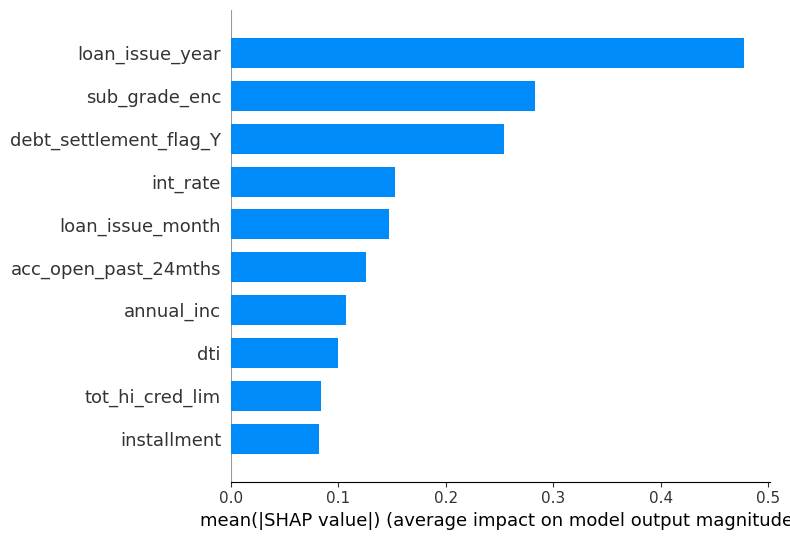

In [23]:
# ─── SHAP SUMMARY (BAR) ─────────────────────────────────────────────────────────
import shap
import matplotlib.pyplot as plt

# Explainer already exists; recompute if needed:
explainer   = shap.TreeExplainer(best_xgb)
X_shap      = X_test.sample(10000, random_state=42)
sv          = explainer.shap_values(X_shap)

# If it's a list (binary classification), pick the SHAP values for class 1:
if isinstance(sv, list):
    sv = sv[1]

# Bar plot of mean |SHAP|
plt.figure(figsize=(8,6))
shap.summary_plot(
    sv, 
    X_shap, 
    plot_type="bar", 
    max_display=10,
    show=True
)



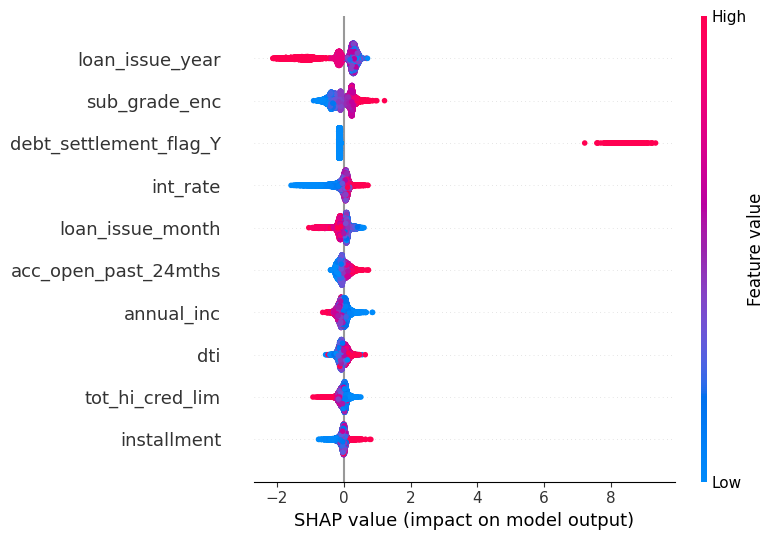

<Figure size 800x600 with 0 Axes>

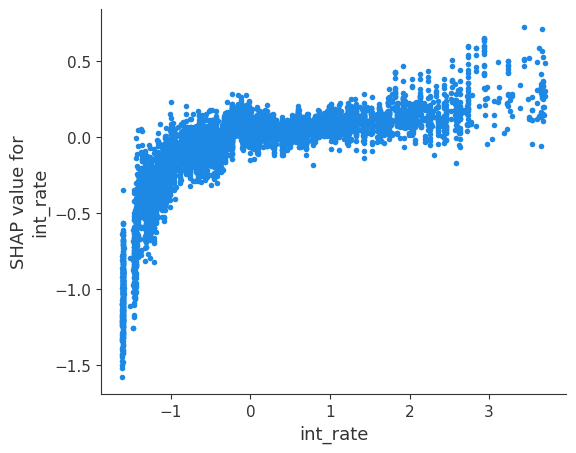

In [24]:
# ─── SHAP BEESWARM & DEPENDENCE FOR int_rate ───────────────────────────────────
import shap
import matplotlib.pyplot as plt

# (Re)use sv from above; if you rerun this cell standalone, recompute sv the same way.
# Beeswarm (dot) summary:
plt.figure(figsize=(8,6))
shap.summary_plot(
    sv, 
    X_shap, 
    plot_type="dot", 
    max_display=10,
    show=True
)

# Dependence plot for a single feature:
plt.figure(figsize=(8,6))
shap.dependence_plot(
    "int_rate",   # feature name 
    sv,           # the class-1 SHAP values array
    X_shap, 
    interaction_index=None, 
    show=True
)



In [25]:
import joblib

# Make sure models/ exists
import os
os.makedirs("models", exist_ok=True)

# Dump the XGBoost model
joblib.dump(best_xgb, "models/xgb_credit.pkl")

print("Saved XGBoost credit model to models/xgb_credit.pkl")


Saved XGBoost credit model to models/xgb_credit.pkl
